
# Sistema de Recomendación de Cultivos con Deep Learning

Este sistema implementa un análisis comparativo de tres arquitecturas diferentes
de redes neuronales para la recomendación de cultivos basada en características
del suelo y condiciones climáticas.

Características principales:
- Preprocesamiento de datos con normalización
- Tres arquitecturas de modelos: DropClassifier, DeepDropoutClassifier, Conv1DClassifier
- Sistema de Early Stopping 
- Comparación sistemática de modelos


Autores: Alan Anthony Hernandez Perez y Luis Carlos Rico Almada.
Fecha: Mayo de 2025.

In [4]:
%pip install torch pandas numpy matplotlib seaborn scikit-learn tabulate

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Verificar dependencias principales
try:
    import sys
    print(f"🐍 Python ejecutable: {sys.executable}")
    print(f"📦 Versión de Python: {sys.version}")
    import torch
    import time
    from tabulate import tabulate
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import MinMaxScaler
    from torch.utils.data import Dataset
    import torch.nn.functional as F
    import torch.nn as nn
    from torch.utils.data import random_split, DataLoader

    import warnings
    print(" Todas las dependencias principales están disponibles")
except ImportError as e:
    print(f" Error importando dependencias: {e}")
    print(" Instala las dependencias con: pip install torch pandas numpy matplotlib seaborn scikit-learn")

🐍 Python ejecutable: c:\Users\Sec. Tec. DGDH\AppData\Local\Programs\Python\Python310\python.exe
📦 Versión de Python: 3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]
 Todas las dependencias principales están disponibles



## SECCIÓN 1: ANÁLISIS EXPLORATORIO Y PREPROCESAMIENTO DE DATOS


Esta sección se encarga de:
1. Cargar y explorar el dataset de recomendación de cultivos
2. Analizar la distribución de características por cultivo
3. Verificar la calidad y balance de los datos
4. Generar visualizaciones exploratorias

El dataset contiene 7 características numéricas:
- N, P, K: Contenido de nutrientes en el suelo (kg/ha)
- temperature: Temperatura promedio (°C)
- humidity: Humedad relativa (%)
- ph: Nivel de pH del suelo
- rainfall: Precipitación anual (mm)

Y una variable objetivo:
- label: Tipo de cultivo recomendado (22 clases diferentes)


In [6]:
# preprocesamiento

print(f"\n ANÁLISIS EXPLORATORIO DE DATOS")
print(f"{'='*50}")

# Cargar dataset principal
try:
    df = pd.read_csv('Crop_recommendation.csv')
    print(f" Dataset cargado exitosamente")
    print(f"📏 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
    print(f"🏷️  Columnas: {list(df.columns)}")
except FileNotFoundError:
    print(f" Error: No se encontró el archivo 'Crop_recommendation.csv'")
    print(f" Asegúrate de que el archivo esté en el directorio actual")
    exit(1)

# Definir características numéricas y obtener cultivos únicos
cols = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
cultivos = df['label'].unique()

print(f"🌾 Cultivos únicos encontrados: {len(cultivos)}")
print(f" Características a analizar: {cols}")


 ANÁLISIS EXPLORATORIO DE DATOS
 Dataset cargado exitosamente
📏 Dimensiones: 2200 filas × 8 columnas
🏷️  Columnas: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
🌾 Cultivos únicos encontrados: 22
 Características a analizar: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


### VISUALIZACIÓN 1: HISTOGRAMAS POR CULTIVO Y CARACTERÍSTICA

Genera histogramas para cada característica agrupados por tipo de cultivo.
Esto permite identificar:
- Rangos típicos de cada característica para cada cultivo
- Distribuciones normales vs sesgadas
- Posibles outliers o valores atípicos
- Separabilidad entre cultivos

In [7]:
print(f"\n Generando histogramas por cultivo...")

for col in cols:
    print(f"    Procesando característica: {col}")

    n_cultivos = len(cultivos)
    ncols = 3  # Número de columnas en la grilla de subplots
    nrows = (n_cultivos + ncols - 1) // ncols  # Calcular filas necesarias

    # Crear figura con subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    fig.suptitle(f'Distribución de {col} por Cultivo', fontsize=16, fontweight='bold')

    # Generar histograma para cada cultivo
    for i, cultivo in enumerate(cultivos):
        ax = axes[i // ncols, i % ncols]
        subset = df[df['label'] == cultivo]

        # Crear histograma con estilo mejorado
        sns.histplot(subset[col], bins=20, kde=False, color="skyblue",
                    alpha=0.7, ax=ax, stat='density')

        # Configurar subplot
        ax.set_title(f'Cultivo: {cultivo}', fontweight='bold')
        ax.set_xlabel(f'{col}')
        ax.set_ylabel('Densidad')
        ax.grid(True, alpha=0.3)

        # Agregar estadísticas básicas
        mean_val = subset[col].mean()
        std_val = subset[col].std()
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7,
                  label=f'Media: {mean_val:.2f}')
        ax.legend(fontsize=8)

    # Eliminar subplots vacíos
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j // ncols, j % ncols])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # plt.show()  # Descomentado para mostrar en entorno interactivo
    plt.close()  # Cerrar para ahorrar memoria


 Generando histogramas por cultivo...
    Procesando característica: N
    Procesando característica: P
    Procesando característica: K
    Procesando característica: temperature
    Procesando característica: humidity
    Procesando característica: ph
    Procesando característica: rainfall


### VISUALIZACIÓN 2: BOXPLOTS PARA ANÁLISIS DE DISTRIBUCIONES Y OUTLIERS

Los boxplots permiten identificar:
- Medianas y cuartiles por cultivo
- Outliers (valores atípicos)
- Rango intercuartílico (IQR)
- Comparación visual entre cultivos

In [8]:
print(f"\n📦 Generando boxplots para análisis de outliers...")

for col in cols:
    print(f"    Boxplot para: {col}")

    plt.figure(figsize=(16, 8))

    # Crear boxplot con estilo mejorado
    box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')

    # Configurar gráfico
    plt.title(f'Distribución de {col} por Cultivo', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Tipo de Cultivo', fontsize=12, fontweight='bold')
    plt.ylabel(f'{col}', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Agregar estadísticas globales
    global_mean = df[col].mean()
    global_median = df[col].median()
    plt.axhline(global_mean, color='red', linestyle='--', alpha=0.7,
               label=f'Media global: {global_mean:.2f}')
    plt.axhline(global_median, color='blue', linestyle='--', alpha=0.7,
               label=f'Mediana global: {global_median:.2f}')
    plt.legend()

    plt.tight_layout()
    # plt.show()  # Descomentado para mostrar en entorno interactivo
    plt.close()  # Cerrar para ahorrar memoria


📦 Generando boxplots para análisis de outliers...
    Boxplot para: N
    Boxplot para: P


C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_28524\1732992763.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')
C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_28524\1732992763.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')


    Boxplot para: K
    Boxplot para: temperature


C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_28524\1732992763.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')
C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_28524\1732992763.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')


    Boxplot para: humidity
    Boxplot para: ph


C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_28524\1732992763.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')
C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_28524\1732992763.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')


    Boxplot para: rainfall


C:\Users\Sec. Tec. DGDH\AppData\Local\Temp\ipykernel_28524\1732992763.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')


### VERIFICACIÓN DE CALIDAD DE DATOS

Esta sección verifica:
1. Presencia de valores nulos o faltantes
2. Balance de clases en el dataset
3. Consistencia de los datos
4. Estadísticas descriptivas básicas

In [9]:
print(f"\n VERIFICACIÓN DE CALIDAD DE DATOS")
print(f"{'='*50}")

# 1. Verificar valores nulos
print(f"\n Análisis de valores nulos:")
valores_nulos = df.isnull().sum()
print(valores_nulos)

if valores_nulos.sum() == 0:
    print(" No se encontraron valores nulos en el dataset")
else:
    print(f" Se encontraron {valores_nulos.sum()} valores nulos")
    print(" Será necesario aplicar técnicas de imputación")

# 2. Verificar balance de clases
print(f"\n Análisis de balance de clases:")
distribucion_cultivos = df['label'].value_counts().sort_index()
print(distribucion_cultivos)

# Calcular estadísticas de balance
min_samples = distribucion_cultivos.min()
max_samples = distribucion_cultivos.max()
mean_samples = distribucion_cultivos.mean()
std_samples = distribucion_cultivos.std()

print(f"\n Estadísticas de distribución:")
print(f"   • Mínimo de muestras por clase: {min_samples}")
print(f"   • Máximo de muestras por clase: {max_samples}")
print(f"   • Promedio de muestras por clase: {mean_samples:.1f}")
print(f"   • Desviación estándar: {std_samples:.1f}")
print(f"   • Ratio max/min: {max_samples/min_samples:.2f}")

# Evaluar balance
if std_samples < mean_samples * 0.1:  # Menos del 10% de variación
    print(" Dataset bien balanceado")
elif std_samples < mean_samples * 0.2:  # Menos del 20% de variación
    print(" Dataset moderadamente balanceado")
else:
    print(" Dataset desbalanceado - considerar técnicas de balanceo")

# 3. Información general del dataset
print(f"\n Información general del dataset:")
print(f"   • Total de muestras: {len(df):,}")
print(f"   • Número de características: {len(cols)}")
print(f"   • Número de clases (cultivos): {df['label'].nunique()}")
print(f"   • Cultivos disponibles: {sorted(df['label'].unique())}")

# 4. Estadísticas descriptivas
print(f"\n Estadísticas descriptivas de características:")
estadisticas = df[cols].describe()
print(estadisticas.round(2))


 VERIFICACIÓN DE CALIDAD DE DATOS

 Análisis de valores nulos:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
 No se encontraron valores nulos en el dataset

 Análisis de balance de clases:
label
apple          100
banana         100
blackgram      100
chickpea       100
coconut        100
coffee         100
cotton         100
grapes         100
jute           100
kidneybeans    100
lentil         100
maize          100
mango          100
mothbeans      100
mungbean       100
muskmelon      100
orange         100
papaya         100
pigeonpeas     100
pomegranate    100
rice           100
watermelon     100
Name: count, dtype: int64

 Estadísticas de distribución:
   • Mínimo de muestras por clase: 100
   • Máximo de muestras por clase: 100
   • Promedio de muestras por clase: 100.0
   • Desviación estándar: 0.0
   • Ratio max/min: 1.00
 Dataset bien balanceado

 Información general de

### Tratamiento de los datos
Esta sección Realiza:
1. Autoencoder de las labes
2. Normalizacion por standarscaler
3. Inserccion de X y Y en tensores
4. Mezcla de los datos

In [10]:
class CropDataset(Dataset):
    def __init__(self, csv_path, export_path=None):
        df = pd.read_csv(csv_path)

        self.feature_columns = df.columns[:-1]
        self.label_column = df.columns[-1]

        # Codificar etiquetas a números

        unique_labels = df[self.label_column].unique()
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

        #generacion de la columna de label encoded
        df['encoded_label'] = df[self.label_column].map(self.label_mapping)

        for crop, idx in self.label_mapping.items():
            print(f"Label: {crop}, Encoded: {idx}")

        # Normalización global
        scaler = MinMaxScaler()
        scaled_features = scaler.fit_transform(df[self.feature_columns])
        normalized_df = pd.DataFrame(scaled_features, columns=self.feature_columns)
        normalized_df['label'] = df[self.label_column]
        normalized_df['encoded_label'] = df['encoded_label']


        # Mezclar datos (shuffle)
        normalized_df = normalized_df.sample(frac=1).reset_index(drop=True)

        # Guardar CSV si se especifica ruta
        if export_path:
            normalized_df.to_csv(export_path, index=False)
            print(f"[INFO] CSV exportado en: {export_path}")

        # Convertir a tensores
        self.X = torch.tensor(normalized_df[self.feature_columns].values, dtype=torch.float32)
        self.y = torch.tensor(normalized_df['encoded_label'].values, dtype=torch.long)

        self.num_classes = len(unique_labels)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def get_x_y(self):
        return self.X, self.y

    def get_label_mapping(self):
        return self.label_mapping

In [11]:
dataset = CropDataset("Crop_recommendation.csv", export_path="Crop_recommendation_normalized.csv")

Label: rice, Encoded: 0
Label: maize, Encoded: 1
Label: chickpea, Encoded: 2
Label: kidneybeans, Encoded: 3
Label: pigeonpeas, Encoded: 4
Label: mothbeans, Encoded: 5
Label: mungbean, Encoded: 6
Label: blackgram, Encoded: 7
Label: lentil, Encoded: 8
Label: pomegranate, Encoded: 9
Label: banana, Encoded: 10
Label: mango, Encoded: 11
Label: grapes, Encoded: 12
Label: watermelon, Encoded: 13
Label: muskmelon, Encoded: 14
Label: apple, Encoded: 15
Label: orange, Encoded: 16
Label: papaya, Encoded: 17
Label: coconut, Encoded: 18
Label: cotton, Encoded: 19
Label: jute, Encoded: 20
Label: coffee, Encoded: 21
[INFO] CSV exportado en: Crop_recommendation_normalized.csv


In [12]:
X, y = dataset[0]
print("Features (X):", X)
print("Etiqueta y", y)
print("Forma de y:", y.shape)

Features (X): tensor([0.2571, 0.3786, 0.1000, 0.5691, 0.5257, 0.7611, 0.0601])
Etiqueta y tensor(5)
Forma de y: torch.Size([])


### Zona de entrenamiento y generacion de metricas a partir de la matriz de confucion a partir de un modelo
Esta sección realiza:
1. Early stopping
2. Funcion de entrenamiento
3. Generacion de los datos de la matriz de confución

In [13]:
def earlyStopping(val_losses, best_moving_avg_loss,
                  patience, epochs_without_improvement, window_size,
                  model, model_name, delta=1e-4, imprimir=True):
    """
    Early Stopping con detección de plateau basado en media móvil de val_loss.

    Args:
        delta (float): mejora mínima requerida para considerar que hay progreso.
    """
    stop = False
    if len(val_losses) >= window_size:
        moving_avg = sum(val_losses[-window_size:]) / window_size
        if imprimir:
            print("Media móvil del loss de validación:", moving_avg)

        if best_moving_avg_loss - moving_avg > delta:
            best_moving_avg_loss = moving_avg
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            if imprimir:
                print("Nueva mejor media móvil. Modelo guardado.")
        else:
            epochs_without_improvement += 1
            if imprimir:
                print("No hubo mejora significativa en el loss de validación.")
                print("Épocas sin mejora:", epochs_without_improvement, "de", patience)
            if epochs_without_improvement >= patience:
                if imprimir:
                    print("Detención temprana activada por plateau.")
                stop = True

    return stop, best_moving_avg_loss, epochs_without_improvement


### todo 
1. comparacion de todas las metricas por modelo
2. porque relu
3. comparar otros modelos con diferentes funciones de activacion

In [14]:
def train_model(model, model_name, train_loader, val_loader, device,imprimir, num_epochs=1000, window_size=10, patience=10):
    """
    Función para entrenar un modelo con early stopping avanzado
    """
    print(f"\n{'='*50}")
    print(f"Entrenando modelo: {model_name}")
    print(f"{'='*50}")

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())

   
    # parametros para Early Stopping
    train_losses = []#listas para graficacion
    val_losses = []

    #variables para metricas de confusion 
    confusion_matrix = np.zeros((dataset.num_classes, dataset.num_classes), dtype=int)
    F1_scoresGlobal = []
    accuracyGlobal = []
    precisionGlobal = []
    recallGlobal = []



    # Parámetros de Early Stopping
    epochs_without_improvement = 0
    best_moving_avg_loss = float('inf')
    best_epoch = 0

    #primero enta en modo de entrenamiento por cada epoca con su reponsable batch
    for epoch in range(num_epochs):
        losses = []

        for train_batch in train_loader:
            x, y = train_batch
            if torch.cuda.is_available():
                x = x.cuda(0)
                y = y.cuda(0)

            y_hat = model(x)
            loss = nn.functional.cross_entropy(y_hat, y)
            losses.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        losses = torch.mean(torch.tensor(losses))
        train_losses.append(losses.item())
        

        # Validación cada epoch para asi determinar si esta mejorando nuestro modelo o si esta overfitting
        model.eval()
        with torch.no_grad():
            val_loss = []

            for val_batch in val_loader:
                x, y = val_batch
                if torch.cuda.is_available():
                    x = x.cuda(0)
                    y = y.cuda(0)

                y_hat = model(x)
                loss = nn.functional.cross_entropy(y_hat, y)
                val_loss.append(loss.item())
                preds = torch.argmax(y_hat, dim=1)
                for t, p in zip(y.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

            val_loss = torch.mean(torch.tensor(val_loss))
            val_losses.append(val_loss.item())
        

            #imprimimos por cada 10 epochs
            if epoch % 10 == 0 and imprimir:
                print(f"Epoca {epoch + 1}/{num_epochs} : Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

            #calculamos los TP, FP, FN, TN de la matriz de confusion
            TP = np.diag(confusion_matrix)
            FP = np.sum(confusion_matrix, axis=0) - TP
            FN = np.sum(confusion_matrix, axis=1) - TP
            TN = np.sum(confusion_matrix) - (TP + FP + FN)
            TP_total = TP.sum()
            FP_total = FP.sum()
            FN_total = FN.sum()
            TN_total = TN.sum()
            
            # Calculamos las metricas de confusion globales
            accuracy = (TP_total + TN_total) / (TP_total + FP_total + FN_total + TN_total)
            precision = TP_total / (TP_total + FP_total) 
            recall = TP_total / (TP_total + FN_total)
            F1_score = 2 * (precision * recall) / (precision + recall)
            F1_scoresGlobal.append(F1_score)
            accuracyGlobal.append(accuracy)
            precisionGlobal.append(precision)
            recallGlobal.append(recall)

            # Verificación de early stopping
            stop, best_moving_avg_loss, epochs_without_improvement = earlyStopping(
                val_losses, best_moving_avg_loss,
                patience, epochs_without_improvement, window_size, model, model_name, delta=1e-4,imprimir = imprimir
            )
            if stop:
                best_epoch = epoch - epochs_without_improvement

                break
        

        model.train()

    if len(val_losses) > best_epoch:
        #quitamos las epocas que no nos importan
        val_losses = val_losses[:best_epoch + 1]
        train_losses = train_losses[:best_epoch + 1]
        F1_scoresGlobal = F1_scoresGlobal[:best_epoch + 1]
        accuracyGlobal = accuracyGlobal[:best_epoch + 1]
        precisionGlobal = precisionGlobal[:best_epoch + 1]
        recallGlobal = recallGlobal[:best_epoch + 1]

    print("Best epoch:", best_epoch)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.tight_layout()
    if imprimir:
        plt.show()

    

    return F1_scoresGlobal, accuracyGlobal, precisionGlobal, recallGlobal, train_losses, val_losses

In [15]:
def evaluate_model(model, val_loader, n_classes):
    """
    Función para evaluar un modelo y calcular métricas
    """
    model.eval()
    matriz_confusion = np.zeros((n_classes, n_classes))

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            if torch.cuda.is_available():
                x_batch = x_batch.cuda(0)
                y_batch = y_batch.cuda(0)
            y_pred = model(x_batch)
            preds = torch.argmax(y_pred, dim=1)
            for t, p in zip(y_batch.view(-1), preds.view(-1)):
                matriz_confusion[t.long(), p.long()] += 1

    # Calcular métricas por clase
    precision = []
    recall = []
    f1_score = []
    accuracy_por_clase = []

    for i in range(n_classes):
        TP = matriz_confusion[i, i]
        FP = matriz_confusion[:, i].sum() - TP
        FN = matriz_confusion[i, :].sum() - TP
        TN = matriz_confusion.sum() - (TP + FP + FN)

        precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score_i = 2 * ((precision_i * recall_i) / (precision_i + recall_i)) if (precision_i + recall_i) > 0 else 0
        accuracy_i = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

        precision.append(precision_i)
        recall.append(recall_i)
        f1_score.append(f1_score_i)
        accuracy_por_clase.append(accuracy_i)

    # Métricas globales
    precision_global = np.mean(precision)
    recall_global = np.mean(recall)
    f1_score_global = 2 * (precision_global * recall_global) / (precision_global + recall_global) if (precision_global + recall_global) > 0 else 0
    accuracy_global = np.mean(accuracy_por_clase)

    label_mapping = dataset.get_label_mapping()

    inverse_label_mapping = {v: k for k, v in label_mapping.items()}
    classes = [inverse_label_mapping[i] for i in range(n_classes)]

    # Imprimir métricas
    df = pd.DataFrame({
        'Cultivo': classes,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy_por_clase
    })
    df.loc["Globales"] = ["—", precision_global, recall_global, f1_score_global, accuracy_global]

    return df, matriz_confusion, precision_global, recall_global, f1_score_global, accuracy_global

### Generacion de las clases de los modelos 
Esta sección hace:
1. Creacion de un dropclassifier siendo una red fully conecte basica
2. Creacion de un dropclassifier siendo una red fully pero con dropout
3. Creacion de un dropclassifier siendo una red CNN


In [16]:
#Generacion de los modelos

class CropClassifier(torch.nn.Module):

    def __init__(self, n_classes, input_size=7, hidden_size=64, opcion= 1):
      super(CropClassifier, self).__init__()
      # Definición de la arquitectura del modelo pero con funciones de activación ReLU 
      if opcion == 1:
        self.encoder = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, n_classes)
        )
      # Definición de la arquitectura del modelo con funciones de activación tan
      else:
        self.encoder = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.Tanh(),
          nn.Linear(hidden_size, hidden_size),
          nn.Tanh(),
          nn.Linear(hidden_size, n_classes)
        )
         


    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_hat = self.encoder(x)
        return y_hat

In [17]:
class simpleDropoutClassifier(torch.nn.Module):
    """      Modelo 3: Red neuronal con  4 capas hidden con 64 neuronas en fully connected y dropout

    """
    def __init__(self, n_classes, input_size=7, hidden_size=64, dropout_rate=0.5, opcion=1):
        
        super(simpleDropoutClassifier, self).__init__()
        # Definición de la arquitectura del modelo con funciones de activación ReLU y dropout
        if opcion == 1:
            self.encoder = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_size, n_classes)
            )
        # Definición de la arquitectura del modelo con funciones de activación tan y dropout
        else:
            self.encoder = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, hidden_size),
                nn.Tanh(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_size, hidden_size),
                nn.Tanh(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_size, n_classes)
            )



    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_hat = self.encoder(x)
        return y_hat


In [18]:
class DeepDropoutClassifier(torch.nn.Module):
    """
    Modelo 2: Red neuronal más profunda con Dropout 
    """
    def __init__(self, n_classes, input_size=7, hidden_sizes=[128, 256, 128, 200, 100, 64], dropout_rate=0.3, opcion=1):
        
        super(DeepDropoutClassifier, self).__init__()
        # Definición de la arquitectura del modelo con funciones de activación ReLU y dropout
        if opcion == 1:
            self.encoder = nn.Sequential(
                nn.Linear(input_size, hidden_sizes[0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_sizes[4], hidden_sizes[5]),
                nn.ReLU(),
                nn.Linear(hidden_sizes[5], n_classes)
            )
        else:
            # Definición de la arquitectura del modelo con funciones de activación tan y dropout
            self.encoder = nn.Sequential(
                nn.Linear(input_size, hidden_sizes[0]),
                nn.Tanh(),
                nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                nn.Tanh(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                nn.Tanh(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                nn.Tanh(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                nn.Tanh(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_sizes[4], hidden_sizes[5]),
                nn.Tanh(),
                nn.Linear(hidden_sizes[5], n_classes)
            )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_hat = self.encoder(x)
        return y_hat


### Módulo de Comparación 

Esta sección verifica:
1. Comparaciones del train loss y val loss por cada modelo
2. Comparación de las metricas a patir del matriz de confusion
3. Comparación de tiempo de ejecución por modelo


In [ ]:
def impresionTablaDiferencias(lista_metrica, lista_nombres_modelos, nombre_metrica):
    """
    Imprime una tabla de diferencias porcentuales entre modelos para una métrica dada,
    usando tabulate. Al inicio imprime el mapeo entre "Modelo X" y el nombre real.

    Args:
        lista_metrica (list): lista de valores de la métrica (float).
        lista_nombres_modelos (list): lista de tuplas, donde el segundo elemento es el nombre real del modelo.
        nombre_metrica (str): nombre de la métrica (e.g., "Precision").
    """
    # Crear nombres genéricos y mapeo
    nombre_modelo = [f"Modelo {i+1}" for i in range(len(lista_nombres_modelos))]
    mapa_nombres = {nombre_modelo[i]: lista_nombres_modelos[i] for i in range(len(lista_nombres_modelos))}

    # Imprimir mapeo ("layers")
    print(f"\nCapas utilizadas para la métrica '{nombre_metrica}':")
    for gen, real in mapa_nombres.items():
        print(f"  {gen}: {real}")

    # Calcular tabla de diferencias porcentuales
    tabla = []
    for i in range(len(lista_metrica)):
        fila = []
        for j in range(len(lista_metrica)):
            if i == j:
                fila.append("-")
            else:
                base = lista_metrica[i] if lista_metrica[i] != 0 else 1e-8
                diff_pct = abs((lista_metrica[i] - lista_metrica[j]) / base) * 100
                fila.append(f"{diff_pct:.2f}")
        tabla.append(fila)

    headers = [""] + nombre_modelo
    tabla_con_filas = [[nombre_modelo[i]] + tabla[i] for i in range(len(nombre_modelo))]

    # Imprimir tabla
    print(f"\nDiferencia porcentual de {nombre_metrica} entre modelos (%):")
    print(tabulate(tabla_con_filas, headers=headers, tablefmt='pretty', floatfmt=".2f"))
    
    

def comparacionModelos(lista_nombres_modelos, train_loader, val_loader,test_loader, device,imprimir=True,
                          num_epochs=1000,  window_size=10, patience=10):
    """
    Entrena múltiples modelos y muestra cuánto tiempo toma cada entrenamiento.

    Args:
        lista_nombres_modelos (list): lista de tuplas (modelo, nombre)
    """
    tiempo_ejecucion = []

    nombre_modelos = []
    f1_scores = []
    accuracies = []
    precisions = []
    recalls = []
    train_losses = []
    val_losses = []

    for model, model_name in lista_nombres_modelos:
        print(f"\n Entrenando modelo: {model_name}")

        start_time = time.time()
        model.to(device)

        f1_score, accuracy, precision, recall, train_loss, val_loss = train_model(
            model, model_name, train_loader, val_loader, device, imprimir,
            num_epochs=num_epochs, window_size=window_size, patience=patience
        )
        nombre_modelos.append(model_name)
        f1_scores.append(f1_score)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        end_time = time.time()
        elapsed = end_time - start_time
        tiempo_ejecucion.append((model_name, elapsed))

    # Graficar métricas comparativas entre modelos
    fig, axs = plt.subplots(3,2, figsize=(18, 12))

    # F1 Score
    for i, model_name in enumerate(nombre_modelos):
        axs[0, 0].plot(f1_scores[i], label=model_name)
    axs[0, 0].set_title("F1 Score por Epoch")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("F1 Score")
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Accuracy
    for i, model_name in enumerate(nombre_modelos):
        axs[0, 1].plot(accuracies[i], label=model_name)
    axs[0, 1].set_title("Accuracy por Epoch")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Accuracy")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Precision
    for i, model_name in enumerate(nombre_modelos):
        axs[1, 0].plot(precisions[i], label=model_name)
    axs[1, 0].set_title("Precision por Epoch")
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Precision")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Recall
    for i, model_name in enumerate(nombre_modelos):
        axs[1, 1].plot(recalls[i], label=model_name)
    axs[1, 1].set_title("Recall por Epoch")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Recall")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # Train Loss
    for i, model_name in enumerate(nombre_modelos):
        axs[2, 0].plot(train_losses[i], label=model_name)
    axs[2, 0].set_title("Train Loss por Epoch")
    axs[2, 0].set_xlabel("Epoch")
    axs[2, 0].set_ylabel("Train Loss")
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    # Validation Loss
    for i, model_name in enumerate(nombre_modelos): 
        axs[2, 1].plot(val_losses[i], label=model_name)
    axs[2, 1].set_title("Validation Loss por Epoch")
    axs[2, 1].set_xlabel("Epoch")
    axs[2, 1].set_ylabel("Validation Loss")
    axs[2, 1].legend()
    axs[2, 1].grid(True)
 

    plt.tight_layout()
    plt.show()
        
    
    precision = []
    recall = []
    f1_score = []
    accuracy = []
    #conseguir las metricas de cada modelo
    for model, model_name in lista_nombres_modelos:
        df, matriz_confusion,precision_global, recall_global, f1_score_global, accuracy_global = evaluate_model(model, test_loader, dataset.num_classes)
        print(f"\n Métricas para el modelo {model_name}:")
        print(tabulate(df, headers='keys', tablefmt='pretty', floatfmt=".2f"))
        #graficar la matriz de confusión como mapa de calor
        print(f"\n Matriz de confusión para el modelo {model_name}:")
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusion, annot=True, fmt=".0f", cmap='Blues',
                   xticklabels=df['Cultivo'], yticklabels=df['Cultivo'])
        plt.title(f"Matriz de Confusión para el modelo {model_name}")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()
        precision.append(precision_global)
        recall.append(recall_global)
        f1_score.append(f1_score_global)
        accuracy.append(accuracy_global)



    #comparacion de diferencias entre modelos mediante la diferencia de metricas
    print("\nDiferencias porcentuales entre modelos:\n")

    impresionTablaDiferencias(precision, nombre_modelos, "Precision")
    impresionTablaDiferencias(recall, nombre_modelos, "Recall")
    impresionTablaDiferencias(f1_score, nombre_modelos, "F1-Score")
    impresionTablaDiferencias(accuracy, nombre_modelos, "Accuracy")
    impresionTablaDiferencias(train_losses, nombre_modelos, "Train Loss")
    impresionTablaDiferencias(val_losses, nombre_modelos, "Validation Loss")
    print(f"\n{'='*50}")


    

    
    


    #impresión de tiempos de entrenamiento
    print("\n Tiempos de entrenamiento por modelo:")
    for model_name, elapsed in tiempo_ejecucion:
        print(f"  • {model_name}: {elapsed:.2f} segundos")
    print(f"\n{'='*50}")
    print(f"Entrenamiento de modelos completado")
    print(f"{'='*50}\n")
        
        


In [29]:
x, y = dataset.get_x_y()
#dataset reunido

dataset_tratado = torch.utils.data.TensorDataset(x, y)

# Dividir el dataset en entrenamiento y prueba
#70% entrenamiento, 30% prueba
train, val, test = random_split(dataset_tratado, [int(len(dataset_tratado) * 0.6), int(len(dataset_tratado) * 0.2), int(len(dataset_tratado) * 0.2)])
#genera los dataloaders,
#ademas de aplicar el shuffle, para utilizar el teorema de limite central
train = DataLoader(train, batch_size=32, shuffle=True)
val= DataLoader(val, batch_size=12, shuffle=True)
test = DataLoader(test, batch_size=12, shuffle=True)

Dispositivo utilizado: cuda

 Entrenando modelo: CropClassifierRelu

Entrenando modelo: CropClassifierRelu
Best epoch: 119


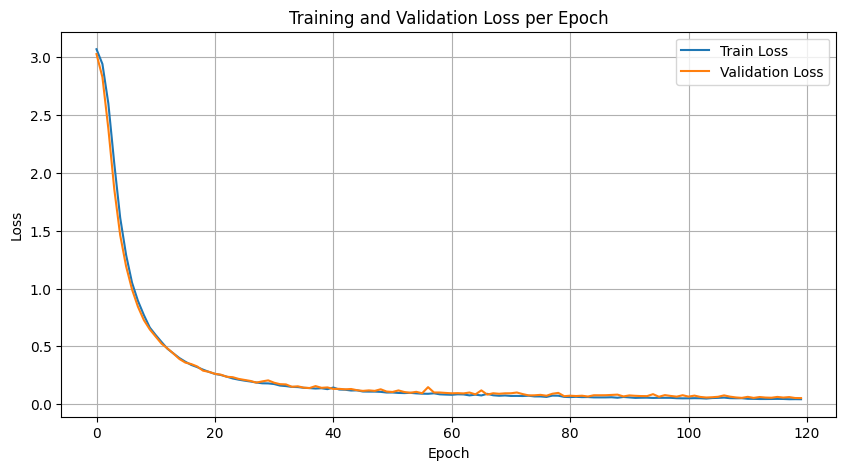


 Entrenando modelo: CropClassifierTanh

Entrenando modelo: CropClassifierTanh
Best epoch: 121


<Figure size 640x480 with 0 Axes>

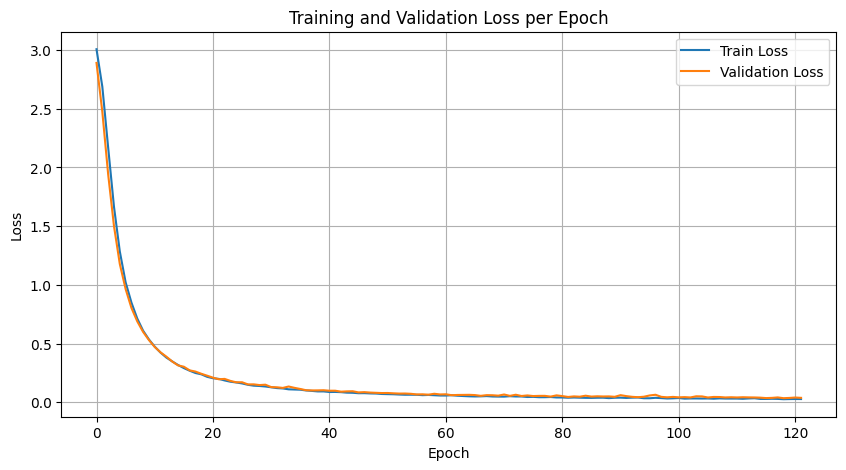


 Entrenando modelo: DeepDropoutClassifierRelu

Entrenando modelo: DeepDropoutClassifierRelu
Best epoch: 59


<Figure size 640x480 with 0 Axes>

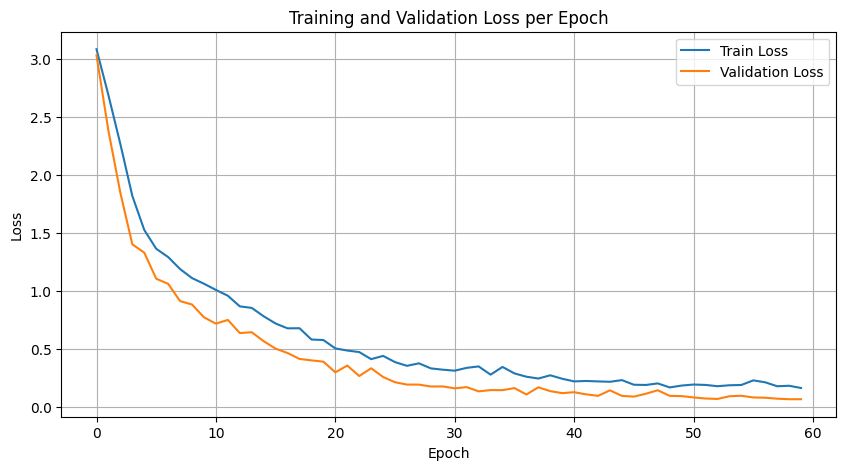


 Entrenando modelo: DeepDropoutClassifierTanh

Entrenando modelo: DeepDropoutClassifierTanh
Best epoch: 48


<Figure size 640x480 with 0 Axes>

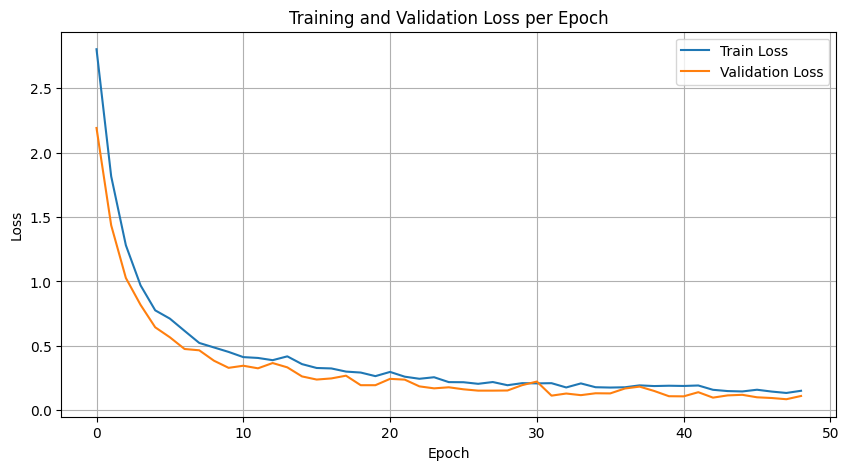


 Entrenando modelo: simpleDropoutClassifierRelu

Entrenando modelo: simpleDropoutClassifierRelu
Best epoch: 182


<Figure size 640x480 with 0 Axes>

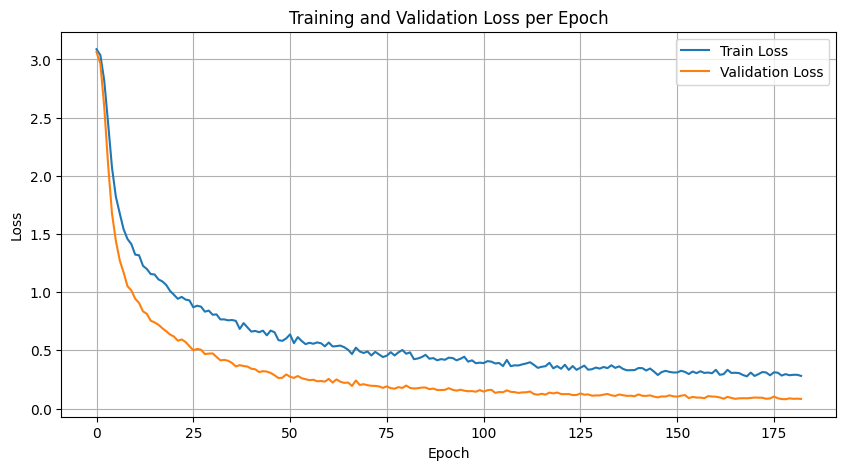


 Entrenando modelo: simpleDropoutClassifierTanh

Entrenando modelo: simpleDropoutClassifierTanh
Best epoch: 110


<Figure size 640x480 with 0 Axes>

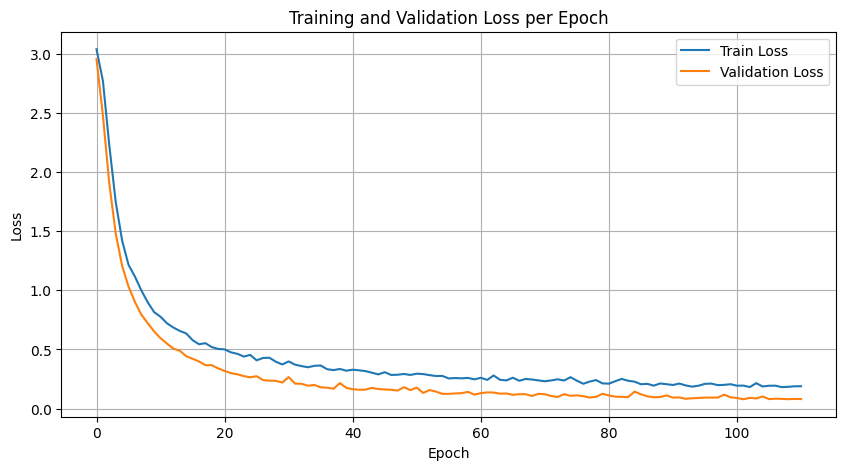

<Figure size 640x480 with 0 Axes>

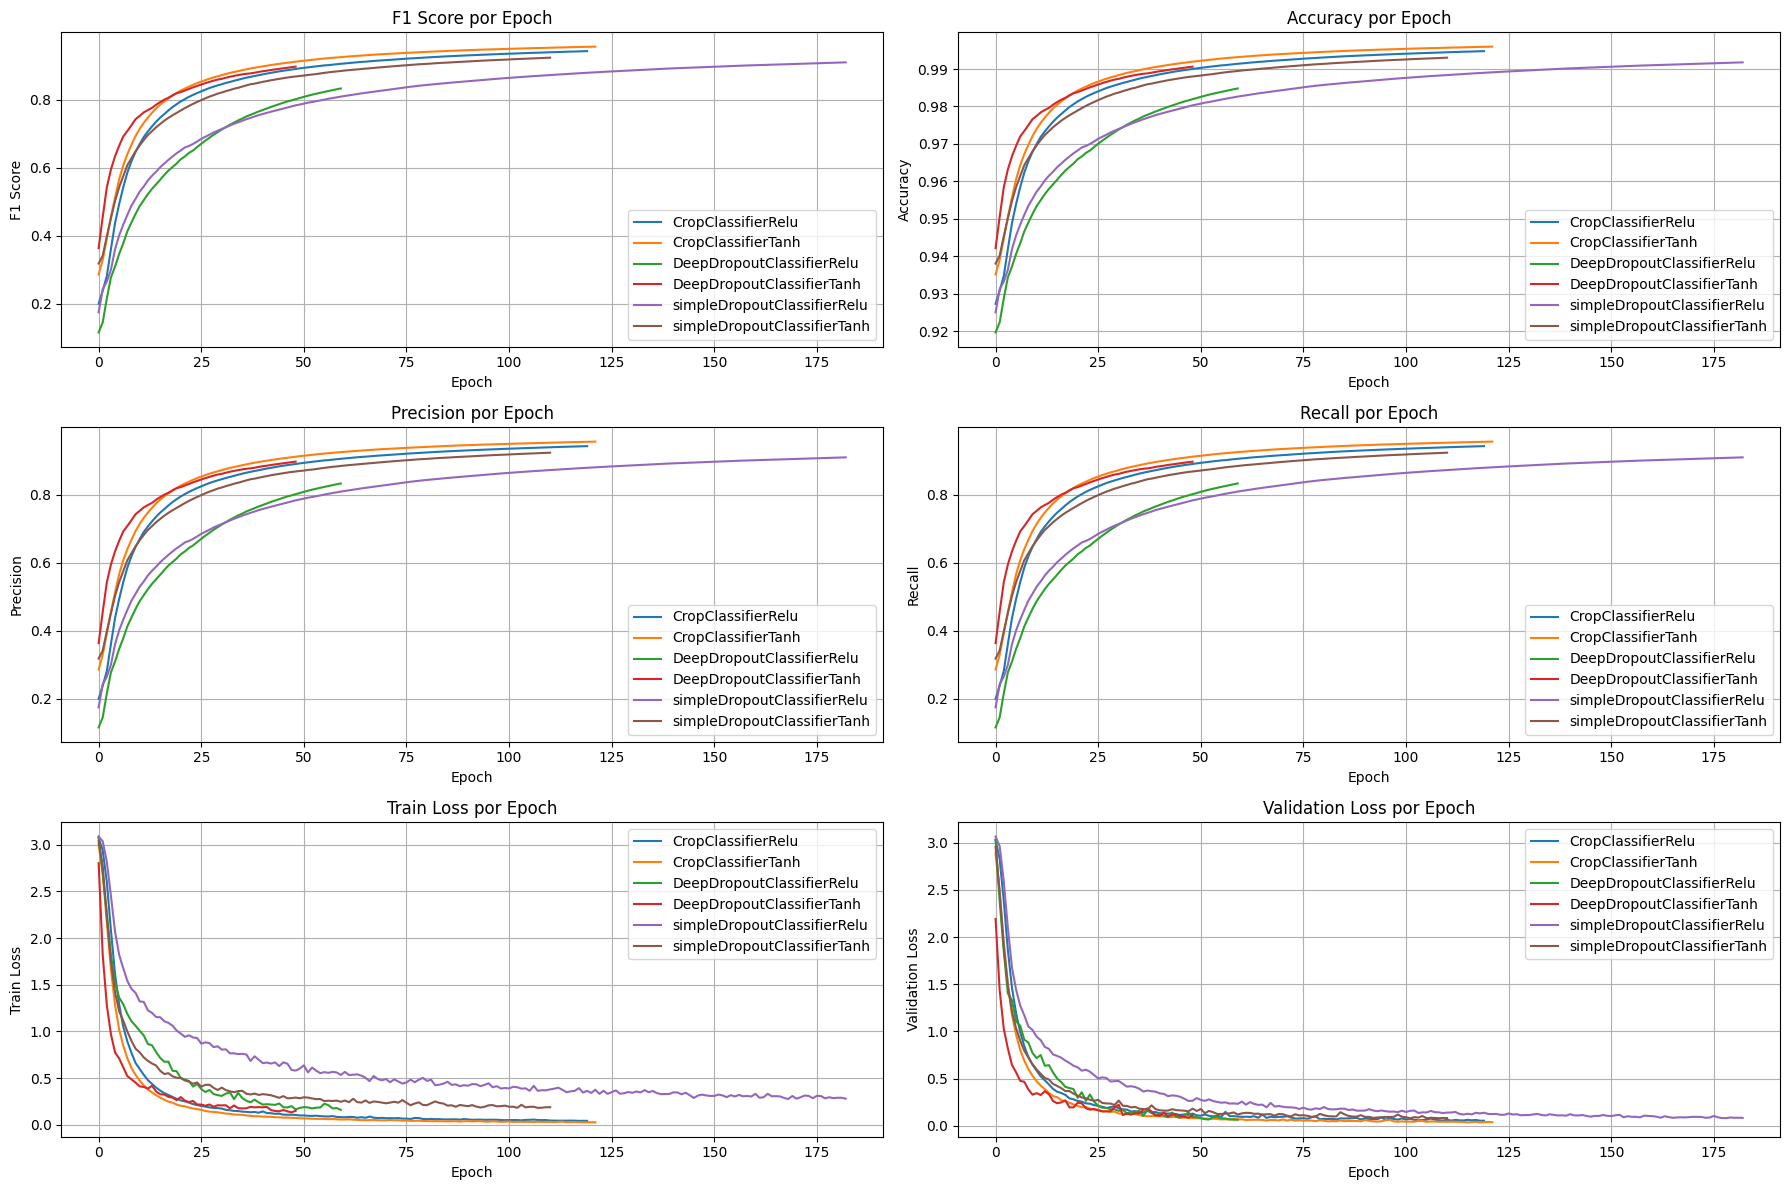


 Métricas para el modelo CropClassifierRelu:
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|          |   Cultivo   |     Precision      |       Recall       |      F1 Score      |      Accuracy      |
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|    0     |    rice     |        1.0         | 0.8333333333333334 | 0.9090909090909091 | 0.990909090909091  |
|    1     |    maize    |        1.0         |        1.0         |        1.0         |        1.0         |
|    2     |  chickpea   |        1.0         |        1.0         |        1.0         |        1.0         |
|    3     | kidneybeans |        1.0         |        1.0         |        1.0         |        1.0         |
|    4     | pigeonpeas  |        1.0         | 0.9473684210526315 | 0.972972972972973  | 0.9977272727272727 |
|    5     |  mothbeans  |        1.0         |        1.0        

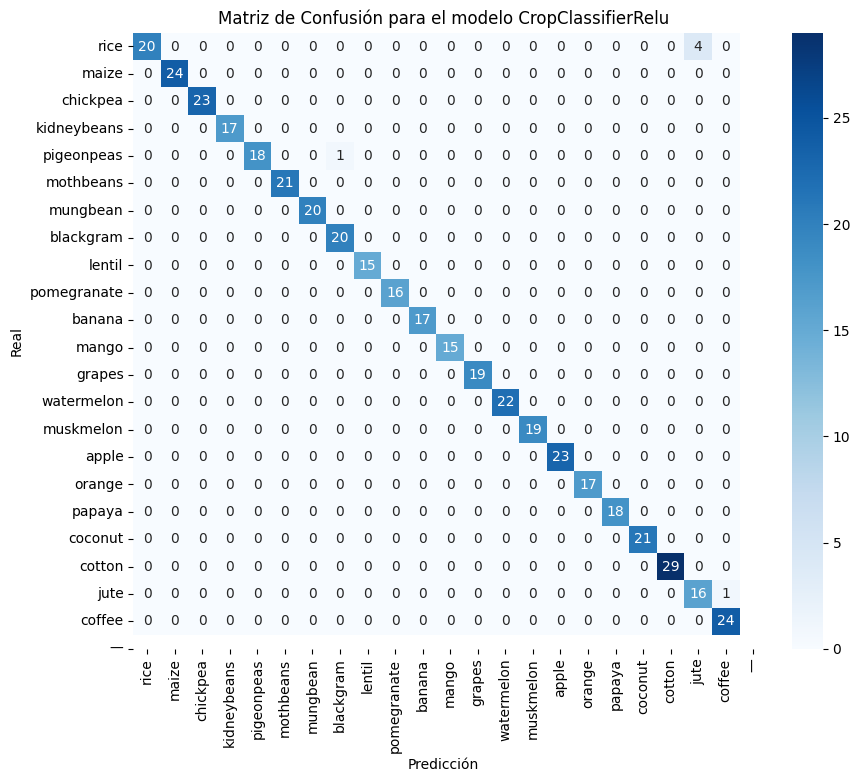


 Métricas para el modelo CropClassifierTanh:
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|          |   Cultivo   |     Precision      |       Recall       |      F1 Score      |      Accuracy      |
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|    0     |    rice     | 0.9545454545454546 |       0.875        | 0.9130434782608695 | 0.990909090909091  |
|    1     |    maize    |        1.0         |        1.0         |        1.0         |        1.0         |
|    2     |  chickpea   |        1.0         |        1.0         |        1.0         |        1.0         |
|    3     | kidneybeans |        1.0         |        1.0         |        1.0         |        1.0         |
|    4     | pigeonpeas  |        1.0         | 0.9473684210526315 | 0.972972972972973  | 0.9977272727272727 |
|    5     |  mothbeans  |        1.0         |        1.0        

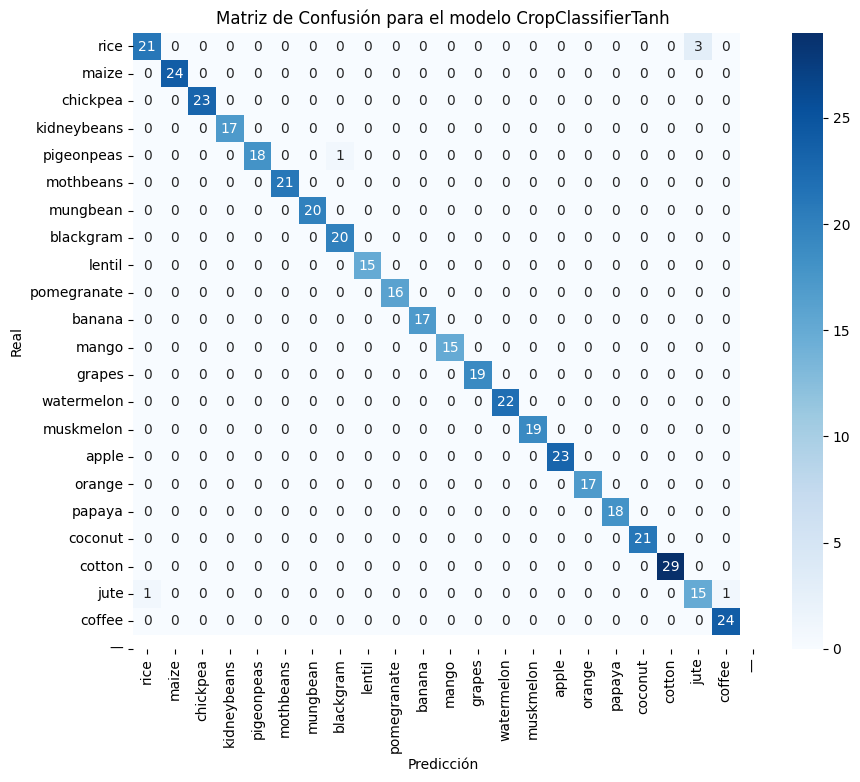


 Métricas para el modelo DeepDropoutClassifierRelu:
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|          |   Cultivo   |     Precision      |       Recall       |      F1 Score      |      Accuracy      |
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|    0     |    rice     | 0.9411764705882353 | 0.6666666666666666 | 0.7804878048780487 | 0.9795454545454545 |
|    1     |    maize    |        0.96        |        1.0         | 0.9795918367346939 | 0.9977272727272727 |
|    2     |  chickpea   |        1.0         |        1.0         |        1.0         |        1.0         |
|    3     | kidneybeans |        1.0         |        1.0         |        1.0         |        1.0         |
|    4     | pigeonpeas  |        1.0         | 0.9473684210526315 | 0.972972972972973  | 0.9977272727272727 |
|    5     |  mothbeans  |        1.0         | 0.952380952

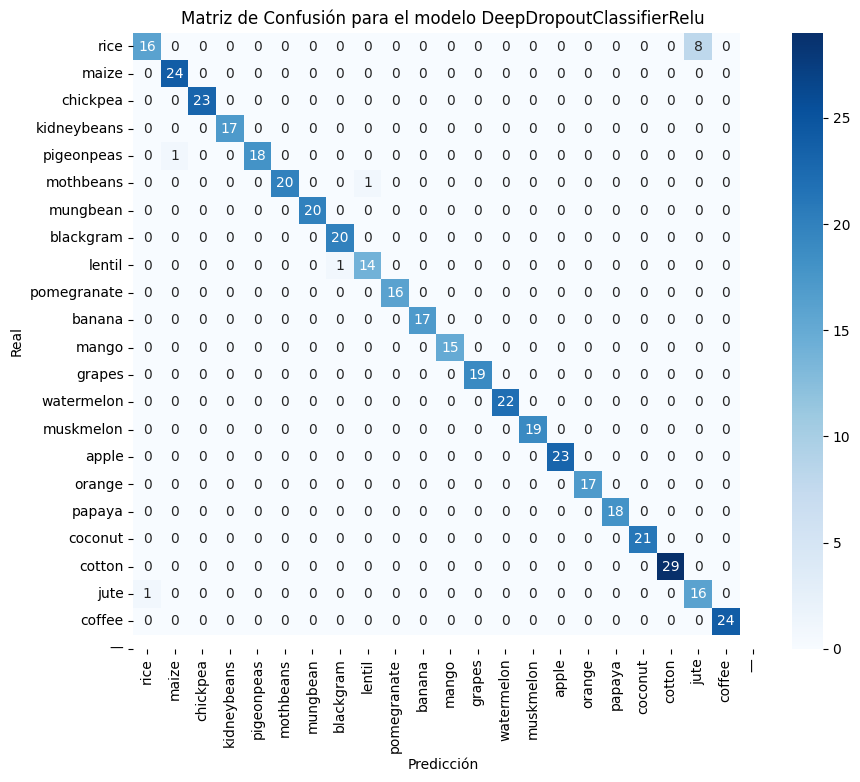


 Métricas para el modelo DeepDropoutClassifierTanh:
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|          |   Cultivo   |     Precision      |       Recall       |      F1 Score      |      Accuracy      |
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|    0     |    rice     |        1.0         | 0.7916666666666666 | 0.8837209302325582 | 0.9886363636363636 |
|    1     |    maize    |        1.0         |        1.0         |        1.0         |        1.0         |
|    2     |  chickpea   |        1.0         |        1.0         |        1.0         |        1.0         |
|    3     | kidneybeans |        1.0         |        1.0         |        1.0         |        1.0         |
|    4     | pigeonpeas  |        1.0         |        1.0         |        1.0         |        1.0         |
|    5     |  mothbeans  |        1.0         | 0.857142857

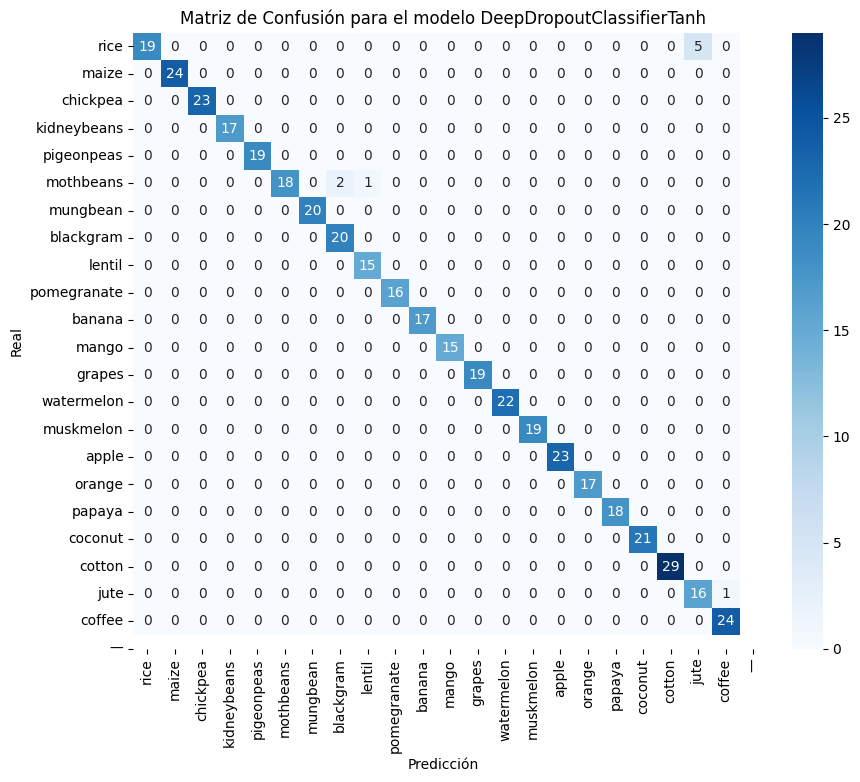


 Métricas para el modelo simpleDropoutClassifierRelu:
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|          |   Cultivo   |     Precision      |       Recall       |      F1 Score      |      Accuracy      |
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|    0     |    rice     |        0.88        | 0.9166666666666666 | 0.8979591836734694 | 0.9886363636363636 |
|    1     |    maize    |        1.0         |        1.0         |        1.0         |        1.0         |
|    2     |  chickpea   |        1.0         |        1.0         |        1.0         |        1.0         |
|    3     | kidneybeans |        1.0         |        1.0         |        1.0         |        1.0         |
|    4     | pigeonpeas  |        1.0         | 0.9473684210526315 | 0.972972972972973  | 0.9977272727272727 |
|    5     |  mothbeans  |        1.0         | 0.9523809

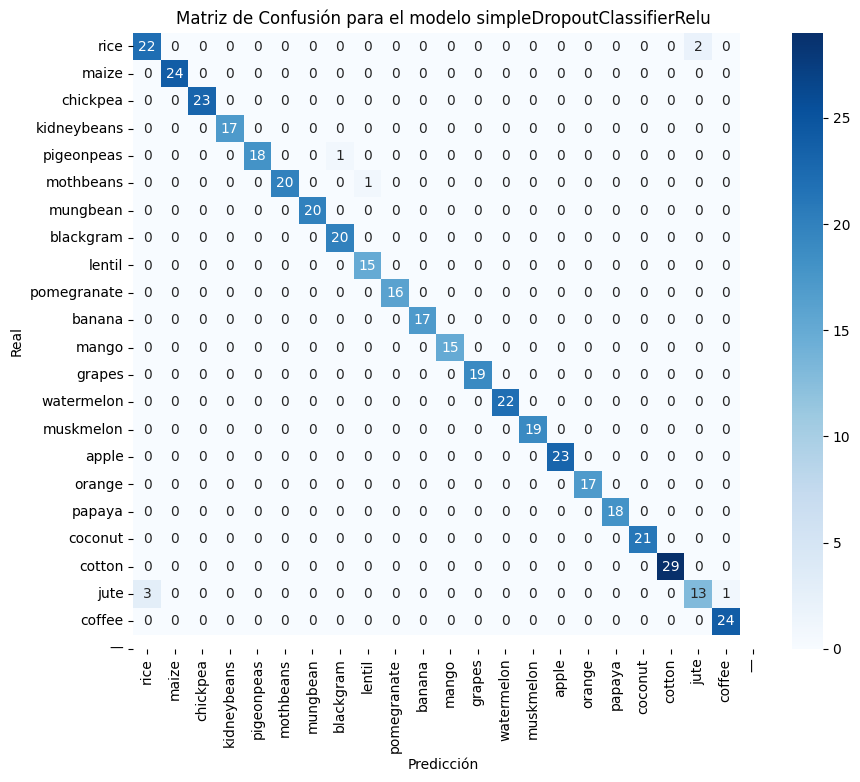


 Métricas para el modelo simpleDropoutClassifierTanh:
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|          |   Cultivo   |     Precision      |       Recall       |      F1 Score      |      Accuracy      |
+----------+-------------+--------------------+--------------------+--------------------+--------------------+
|    0     |    rice     |        0.88        | 0.9166666666666666 | 0.8979591836734694 | 0.9886363636363636 |
|    1     |    maize    |        1.0         |        1.0         |        1.0         |        1.0         |
|    2     |  chickpea   |        1.0         |        1.0         |        1.0         |        1.0         |
|    3     | kidneybeans |        1.0         |        1.0         |        1.0         |        1.0         |
|    4     | pigeonpeas  |        1.0         | 0.9473684210526315 | 0.972972972972973  | 0.9977272727272727 |
|    5     |  mothbeans  | 0.8695652173913043 | 0.9523809

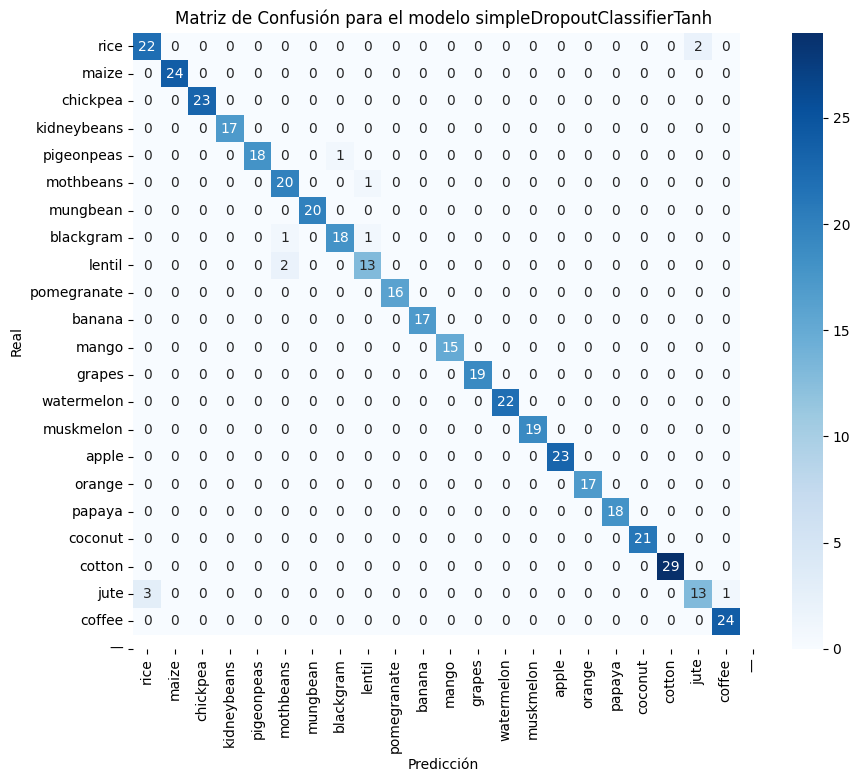


Diferencias porcentuales entre modelos:


Capas utilizadas para la métrica 'Precision':
  Modelo 1: CropClassifierRelu
  Modelo 2: CropClassifierTanh
  Modelo 3: DeepDropoutClassifierRelu
  Modelo 4: DeepDropoutClassifierTanh
  Modelo 5: simpleDropoutClassifierRelu
  Modelo 6: simpleDropoutClassifierTanh

Diferencia porcentual de Precision entre modelos (%):
+----------+----------+----------+----------+----------+----------+----------+
|          | Modelo 1 | Modelo 2 | Modelo 3 | Modelo 4 | Modelo 5 | Modelo 6 |
+----------+----------+----------+----------+----------+----------+----------+
| Modelo 1 |    -     |   0.06   |   1.19   |   0.66   |   0.53   |   1.48   |
| Modelo 2 |   0.06   |    -     |   1.14   |   0.61   |   0.48   |   1.43   |
| Modelo 3 |   1.21   |   1.15   |    -     |   0.54   |   0.67   |   0.30   |
| Modelo 4 |   0.67   |   0.61   |   0.53   |    -     |   0.13   |   0.83   |
| Modelo 5 |   0.54   |   0.48   |   0.66   |   0.13   |    -     |   0.96   |
| Mode

In [30]:
modelos = [
    (CropClassifier(dataset.num_classes), "CropClassifierRelu"),
    (CropClassifier(dataset.num_classes, opcion=2), "CropClassifierTanh"),
    (DeepDropoutClassifier(dataset.num_classes), "DeepDropoutClassifierRelu"),
    (DeepDropoutClassifier(dataset.num_classes, opcion=2), "DeepDropoutClassifierTanh"),
    (simpleDropoutClassifier(dataset.num_classes), "simpleDropoutClassifierRelu"),
    (simpleDropoutClassifier(dataset.num_classes, opcion=2), "simpleDropoutClassifierTanh")
]

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")
# Entrenar múltiples modelos
comparacionModelos(modelos, train, val,test, device, False)